# analysis of the **target mesh** (cylindrical)

Opens the mesh data, analyses them and plots them.

---

In [1]:
%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm

pi = 3.1415926535

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize']=20

cmap = "RdYlBu_r"

### general settings (here below) and file opening

In [2]:
path = "./out_data"  # path to main data folder

# scan parameters
orientation_ls = ["random", "axial"]

# fixed parameters
nEvs = 100
energy = 120
shape = "Cylinder"
thickness = 100
dThickness = thickness/400
halfSection = 20
dHalfSection = halfSection/400  # note: dHalfSection is the full bin size along the radius (Cylinder) or the whole side (Box)

# mesh plot settings
rLim = 5
bLog = False
upperLim = None
scorer = "eDep"  # eDep / nTracks / nSecondaries
thicknessLim = 50
radiusLim = 2
thicknessMin = 2*dThickness

---

In [3]:
def filename():
    return "%s/%s_%dGeV_%d/outMesh_%s.csv" % (path, dataset, energy, nEvs, scorer)

data = {}

for dataset in orientation_ls:
    print("loading %s data, w/ nr. of events %d" %(dataset, nEvs))

    data[dataset] = {}
    
    data[dataset] = pd.read_csv(
        filename(), skiprows=3,
        names=["ind_z", "ind_phi", "ind_r", scorer, "useless0", "useless1"]

    ).drop(columns=["useless0", "useless1"])
    
    # physical position inside the mesh data
    data[dataset]["z"] = dThickness * (data[dataset]["ind_z"] + 0.5)  # central z [mm]
    data[dataset]["rSign"] = 2*data[dataset]["ind_phi"] - 1  # r sign (positive in half of the azimut, negative elsewhere)
    data[dataset]["r"] = dHalfSection * (data[dataset]["ind_r"] + 0.5) * data[dataset]["rSign"]  # signed central r [mm]
    data[dataset]["rUnsigned"] = data[dataset]["r"] * data[dataset]["rSign"]  # unsigned central r [mm]
    data[dataset]["r0"] = dHalfSection * (data[dataset]["ind_r"])  # inner r [mm]
    data[dataset]["r1"] = dHalfSection * (data[dataset]["ind_r"] + 1)  # outer r [mm]

    if scorer=="eDep":
        data[dataset]["eDensityPerElectron"] = 1 / nEvs * data[dataset]["eDep"] / \
            ((dThickness) * (pi*(data[dataset]["r1"]**2 - data[dataset]["r0"]**2)))  # energy density per electron [MeV/mm**3]
    if scorer=="nTracks":
        data[dataset]["trackDensityPerElectron"] = 1 / nEvs * data[dataset]["nTracks"] / \
            ((dThickness) * (pi*(data[dataset]["r1"]**2 - data[dataset]["r0"]**2)))  # track density per electron [#/mm**3]
    if scorer=="nSecondaries":
        data[dataset]["secondaryDensityPerElectron"] = 1 / nEvs * data[dataset]["nSecondaries"] / \
            ((dThickness) * (pi*(data[dataset]["r1"]**2 - data[dataset]["r0"]**2)))  # density of secondaries produced per electron [#/mm**3]

loading random data, w/ nr. of events 100
loading axial data, w/ nr. of events 100


### plot/fit

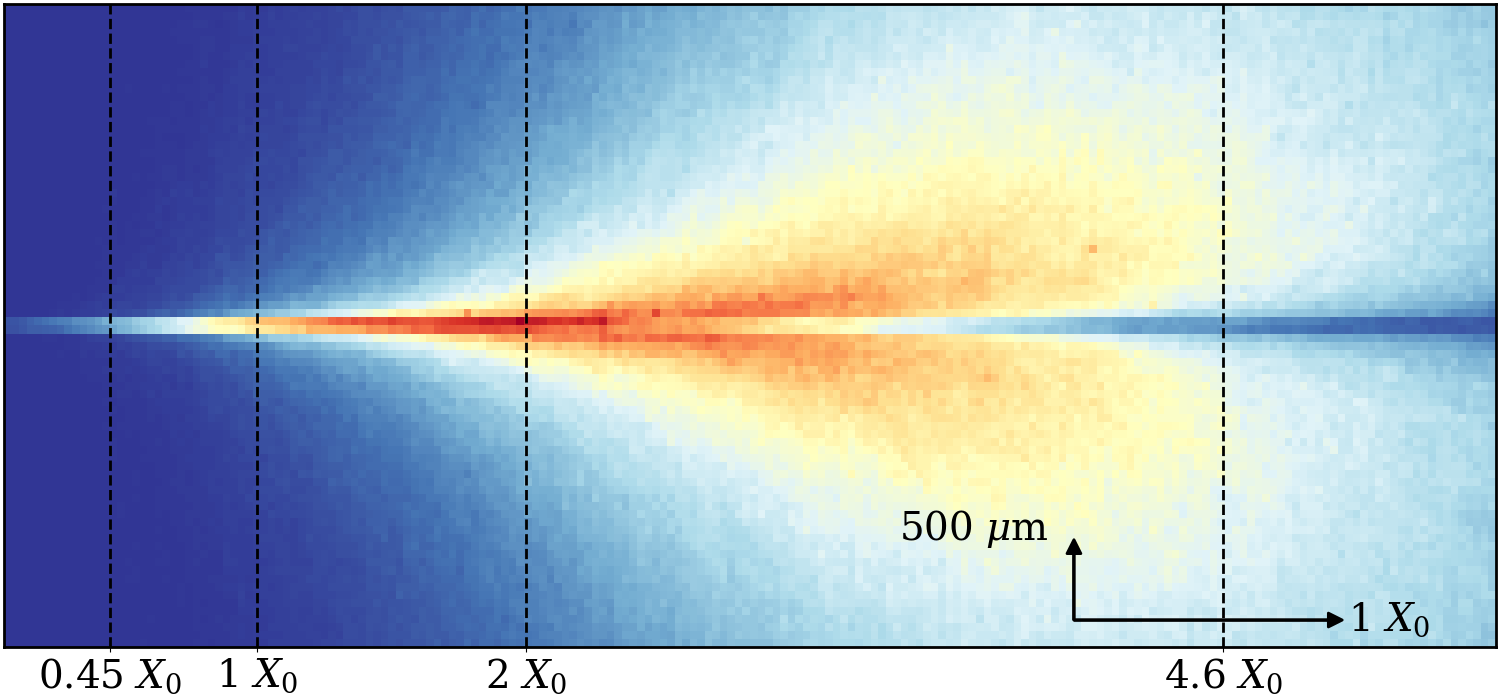

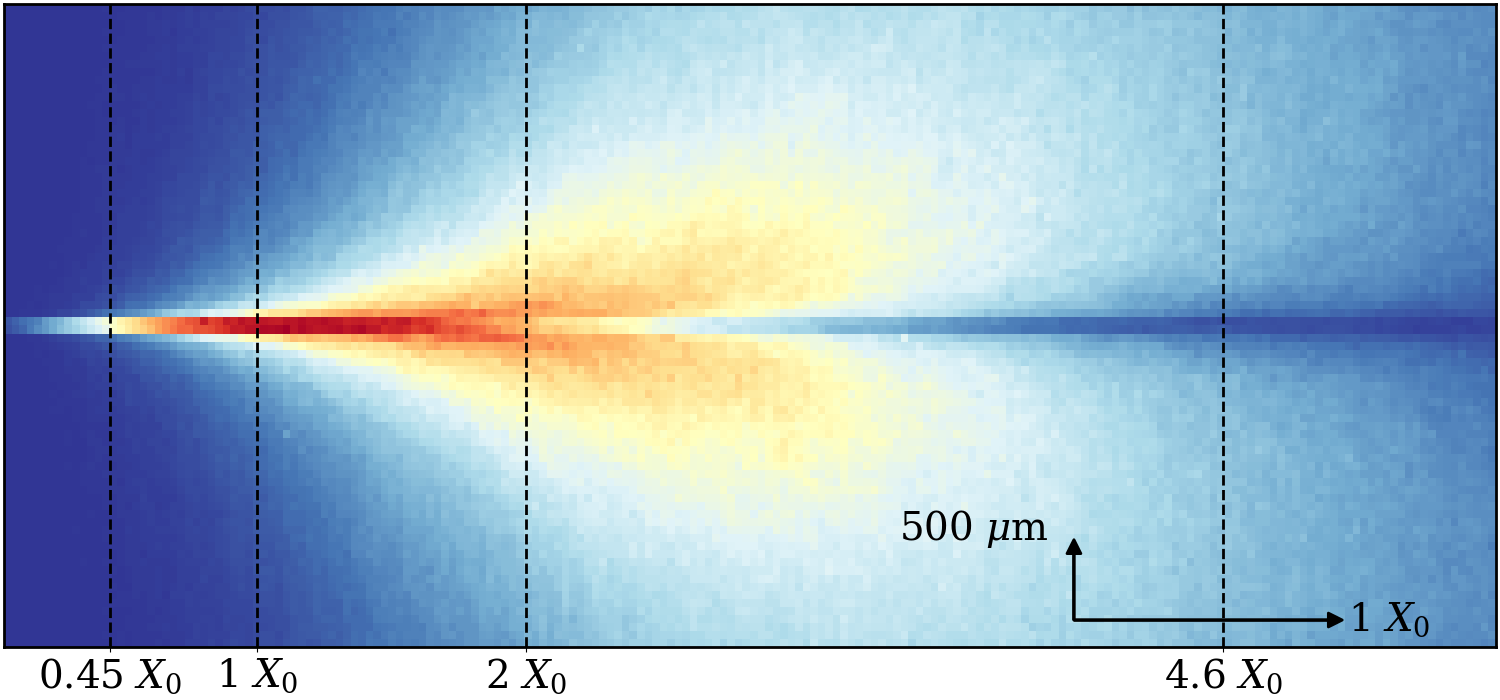

In [4]:
# radius-vs-thickness energy density mesh

width = 15
height = 7

fontsize=28

if True:

    for idataset, dataset in enumerate(orientation_ls):

        plt.close("mesh2d_%s"%dataset)
        fig, ax = plt.subplots(num = "mesh2d_%s"%dataset, figsize = [width, height], constrained_layout=True)
        
        bData = (data[dataset]["rUnsigned"] < rLim if rLim!=None else data[dataset]["rUnsigned"] < 1e5) & (data[dataset]["z"] > thicknessMin)
        Z, R = np.meshgrid(
            sorted(list(set(data[dataset][bData]["z"]))),
            sorted(list(set(data[dataset][bData]["r"]))),
        )
        ED = interpolate.griddata(
            (data[dataset][bData]["z"], data[dataset][bData]["r"]),
            data[dataset][bData][scorer], (Z, R), method='nearest'
        )
        plotmesh = ax.pcolormesh(Z, R, ED, shading="nearest", norm=LogNorm() if bLog else None, cmap=cmap)
        #ax.set_aspect(height/width)
        ax.set_xlim((thicknessMin, thicknessLim))
        ax.set_ylim((-radiusLim, radiusLim))
        ax.grid(False)
        ax.axis('on')
        ax.set_xticks(
            [0.45*8.903, 1*8.903, 2*8.903, 4.6*8.903], 
            [r"$0.45~X_0$", r"$1~X_0$", r"$2~X_0$", r"$4.6~X_0$"],
            fontsize=fontsize
        )  
        ax.set_yticks([])  
        plt.setp(ax.spines.values(), lw=2)

        ax.axvline(x=0.45*8.903, color="k", lw=2, ls="--")
        ax.axvline(x=   1*8.903, color="k", lw=2, ls="--")
        ax.axvline(x=   2*8.903, color="k", lw=2, ls="--")
        ax.axvline(x= 4.6*8.903, color="k", lw=2, ls="--")

        deltay = 500/1e3  # radiusLim/6
        
        ax.annotate('', (36, -radiusLim*2/3), (36, -radiusLim*2/3-deltay), arrowprops=dict(width=0.1, headwidth=10, headlength=10, lw=2, color="k"))
        ax.text(36+0.3-6.1, -radiusLim*2/3, r"$%d~\mu\mathrm{m}$" % (deltay*1e3), horizontalalignment="left", fontsize=fontsize)

        ax.annotate('', (36+8.903, -radiusLim*2/3-deltay), (36, -radiusLim*2/3-deltay), arrowprops=dict(width=0.1, headwidth=10, headlength=10, lw=2, color="k"))
        ax.text(36+0.2+8.903, -radiusLim*2/3-deltay, r"$1~X_0$", horizontalalignment="left", verticalalignment="center", fontsize=fontsize)

        fig.savefig("./mesh_%s.png"%dataset, dpi = 500)
    
# 1d projection - energy density vs thickness (@ ind_r = 0)
if False:
    plt.close("mesh1d")

    fig, ax = plt.subplots(num = "mesh1d", figsize = [width, 7], nrows=len(orientation_ls), sharex=True, constrained_layout=True)

    for idataset, dataset in enumerate(orientation_ls):
    
        for ind_r in [0, 4, 9, 19]:
            ind_r_eff = int(ind_r * 0.1 / dHalfSection)
            bData = (data[dataset]["ind_r"] == ind_r_eff) & (data[dataset]["z"] > thicknessMin)
            ax[idataset].plot(
                data[dataset][bData]["z"], data[dataset][bData][scorer],
                label = "transverse bin nr. %d" % ind_r_eff
            )
        ax[idataset].set_xlim((thicknessMin, thickness))
        ax[idataset].set_ylim((0, upperLim))
        ax[idataset].grid()
        ax[idataset].legend()
        
        fig.supxlabel("longitudinal depth [mm]", fontsize=fontsize)
        fig.supylabel(r"energy density per projectile [MeV/(mm$^3$ electron)]", fontsize=fontsize)
    
    fig.suptitle("thickness = %.3f mm" % thickness)